In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.15, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!  

In [ ]:
import cuml

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
import sys, gc
import seaborn as sns
import random
from itertools import chain
from tqdm.notebook import tqdm
import math
import scipy as si
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from sklearn.preprocessing import PolynomialFeatures


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import torch 
from torch import matmul
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.distributions as tdist
print('GPU available: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU available:  True


# 0 Some tool functions

In [ ]:
def KMeans(x, K=10, Niter=1, verbose=False):
    x = x.cpu()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[np.random.permutation(N)[:K], :].clone()  # Simplistic random initialization
    x_i = x[:, None, :]  # (Npoints, 1, D)

    for i in range(Niter):

        c_j = c[None, :, :]  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torch.float32)  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c

# 1 Data simulator

In [ ]:
class call_pricing_generator:

    def __init__(self, dim_X = 5, T = 1.5, r = 0.025, random_state = None) :
        self.dim_X = dim_X
        self.K = np.random.RandomState(random_state).uniform(80, 120, dim_X)
        self.T = T
        self.r = r
        self.sigma = np.random.RandomState(random_state).uniform(0.1,0.5, dim_X)
        self.omega = np.random.RandomState(random_state).uniform(0.,1., dim_X)
  
    def print_para(self):
        return {'dim_X': self.dim_X, 'K': self.K, 'T': self.T, 'r': self.r, 
                'sigma': self.sigma, 'omega': self.omega}

    def simulate(self, N_sim = 10000, random_state = None):
        payoff = np.zeros([N_sim, self.dim_X])
        price = np.zeros([N_sim, self.dim_X])
        S0 = np.zeros([N_sim, self.dim_X])
        for i in range(self.dim_X):
            S0[:,i] = np.random.RandomState(random_state).uniform(10+i*5, 180+i*5, N_sim)
            ST = S0[:,i]*np.exp((self.r-0.5*self.sigma[i]**2)*self.T+self.sigma[i]*np.sqrt(self.T)*np.random.normal(size=N_sim))
            payoff[:,i] = np.exp(-self.r*self.T)*np.maximum(ST-self.K[i], 0)
            d1 = (np.log(S0[:,i]/self.K[i])+(self.r+0.5*self.sigma[i]**2)*self.T)/(self.sigma[i]*np.sqrt(self.T))
            d2 = d1 - self.sigma[i]*np.sqrt(self.T)
            price[:,i] = S0[:,i]*norm.cdf(d1)-np.exp(-self.r*self.T)*self.K[i]*norm.cdf(d2)
            
        payoff = np.sum(payoff*self.omega, axis = 1)
        price = np.sum(price*self.omega, axis = 1)
        return (torch.from_numpy(S0.reshape(-1,self.dim_X)).type(torch.FloatTensor),
                torch.from_numpy(payoff.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(price.reshape(-1,1)).type(torch.FloatTensor))

In [ ]:
class var_es_generator:

    def __init__(self, X_dim = 20, eps = 0.025, lambda_rs = 10, mu_rs = 20):
        self.X_dim = X_dim
        self.eps = eps
        self.lambda_rs = lambda_rs
        self.mu_rs = mu_rs
        
    
    def mean_X(self):
        return np.zeros(self.X_dim)
    
    def var_X(self):
        return np.identity(self.X_dim)

    def cond_mean_std_Y(self, X, weight_vector): 
        poly = PolynomialFeatures(2)
        return np.sum(poly.fit_transform(X) * weight_vector, axis = 1)
    
    def simulate(self, nb_simulation = 10000, lambda_0 = 10., mu_0 = 3.) :
        X = np.random.multivariate_normal(self.mean_X(), self.var_X(), nb_simulation)
        #lambda vector : P1(x) = lambda_0 + sum lambda_i*xi + sum lambda_ij*xi*xj
        self.lambda_vector = np.append(lambda_0, np.random.RandomState(self.lambda_rs).normal(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        #mu vector : P2(x) = mu_0 + sum mu_i*xi + sum mu_ij*xi*xj
        self.mu_vector = np.append(mu_0, np.random.RandomState(self.mu_rs).normal(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        mean_Y = self.cond_mean_std_Y(X, self.lambda_vector)
        std_Y = self.cond_mean_std_Y(X, self.mu_vector)
        std_Y = np.sqrt(std_Y**2)
        
        Y = np.random.normal(mean_Y, std_Y)

        true_VaR = mean_Y - std_Y*norm.ppf(self.eps)
        true_ES = mean_Y + 1/self.eps * std_Y * norm.pdf(norm.ppf(self.eps)) 

        return (torch.from_numpy(X.reshape(nb_simulation, self.X_dim)).type(torch.FloatTensor), 
                torch.from_numpy(Y.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_VaR.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_ES.reshape(-1,1)).type(torch.FloatTensor),
                mean_Y,
                std_Y)

In [ ]:
test = var_es_generator(X_dim = 5)
X_train, Y_train, true_VaR, true_ES, mean_Y,_ = test.simulate(10000, lambda_0= 20, mu_0 = 10)

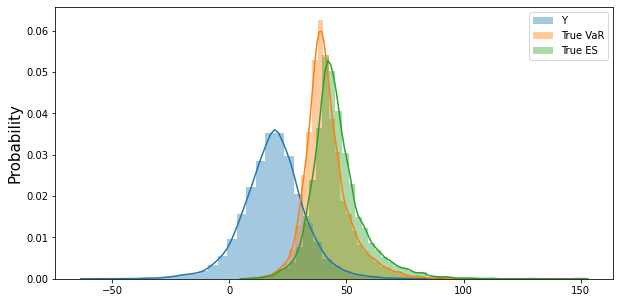

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(Y_train.data, label='Y')
sns.distplot(true_VaR.data, label='True VaR')
sns.distplot(true_ES.data, label='True ES')
plt.title("", fontsize=12)
plt.xlabel("")
plt.ylabel("Probability", fontsize=15)
plt.legend()

#2 Randomized layers

In [ ]:
class Randomprojection:

    def __init__(self, Layers = [10, 100], random_state = None, bias = True, activation = F.relu, projection = 'Gauss'):
        if projection == 'Gauss':
            dist = tdist.normal.Normal(0., 1.)
        elif projection == 'Rademacher':
            dist = Rademacher_dist
        elif projection == 'Achlioptas':
            dist = Achlioptas_dist

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    torch.manual_seed(2*random_state+i)
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        self.activation = activation
        self.bias = bias
    def fit_transform(self, X):
        X = X.to(device)
        if self.bias:
            for W,b in zip(self.W, self.b):
                X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        else :
            for W in self.W:
                X = self.activation(torch.matmul(X, W.to(device)))
        return X

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, Layers = [1,20,40], activation = F.relu):
        super(Autoencoder, self).__init__()
        self.hidden = nn.ModuleList()
        # Example: Encoder 1 - 20 - 40 and Decoder 40 - 20 - 1
        Layers = Layers + Layers[::-1]
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        self.activation = activation

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

    def forward_central_layer(self, x):
        x = x.to(device)
        L = int(len(self.hidden) / 2)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [ ]:
class RBFlayer:
    """RBFlayer.
    Parameters
    ----------
    function: 
        'Gaussian', 'Multiquadric', 'Inverse quadratic' or 'Thin plate spline'.
    """

    def __init__(self, output_layer = 100, e = 1/2, function = 'gaussian'):
        self.K = output_layer
        if function.capitalize() == 'Gaussian' :
            self.activation = lambda x: torch.exp(-e*x)
        elif function.capitalize() == 'Multiquadric':
            self.activation = lambda x: torch.sqrt(1+e*x)
        elif function.capitalize() == 'Inverse quadratic':
            self.activation = lambda x: 1/(1+e*x)
        elif function.capitalize() == 'Thin plate spline':
            self.activation = lambda x: (x**2*torch.log(torch.clamp(x, min=1e-40) )).type(torch.float)


    def fit(self, X):
        _, self.centroids = KMeans(X, self.K, 1)
          
    def transform(self, X):
        self.centroids = self.centroids.to(device)
        dist= torch.empty((X.shape[0],self.K), dtype= torch.float)
        for j in range(self.K):
            dist[:,j] = torch.norm(X - self.centroids[j], dim = 1)
        return self.activation(dist**2)


#3 Readout layers

In [ ]:
from sklearn.linear_model import LinearRegression

class LR_readout:
    
    def __init__(self, intercept = True, normalize=False, regularization_weight = 0):
        if regularization_weight == 0:
            self.lin_reg = LinearRegression(fit_intercept=intercept, normalize=normalize, n_jobs=-1)
        else:
            self.lin_reg = Ridge(alpha = regularization_weight, solver = 'cholesky',
                                 fit_intercept=intercept, normalize=normalize)

    def fit(self, X, y):
        self.lin_reg.fit(X.cpu(),y.cpu())
        self.coef = torch.tensor(self.lin_reg.coef_.T)
    def predict(self, X) :
        
        return torch.from_numpy(self.lin_reg.predict(X.cpu())).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y, weight = 1):
        return torch.mean((self.predict(X)*weight - y)**2)

In [ ]:
class LR_readout_cuml:
    
    def __init__(self, intercept = True, normalize=False, regularization_weight = 0):
        if regularization_weight == 0:
            self.lin_reg = cuml.LinearRegression(fit_intercept=intercept, normalize=normalize,
                                                 output_type='numpy')
        else:
            self.lin_reg = cuml.Ridge(alpha=regularization_weight, 
                                      fit_intercept=intercept, normalize=normalize, 
                                      output_type='numpy')

    def fit(self, X, y):
        self.lin_reg.fit(X,y)
    def predict(self, X) :
        
        return torch.from_numpy(self.lin_reg.predict(X)).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y, weight = 1):
        return torch.mean((self.predict(X)*weight - y.reshape(-1))**2)

In [ ]:
class NN_nlayers(nn.Module):

    def __init__(self, Layers, activation = F.relu):
        super(NN_nlayers, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        self.activation = activation

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [ ]:
def train_quad_loss(model, X_train, y_train, eps = 1e-8, epochs=300, verbose = None):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    i = 0
    err = np.inf
    while (err >= eps) and (i < epochs):
        optimizer.zero_grad()
        pred = model.forward(X_train)
        loss = torch.mean((pred - y_train)**2)
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1

## Optimal gradient descent learning rate for a quadratic loss function

Considering a quadratic loss for an input matrix ${X}$ (can include a one column vector relating the biais) and an output vector $y$
$$\mathcal{L}(A,b) = \mathbb{E} \left[ || {X}\underbrace{A}_{weight} + \underbrace{b}_{bias} - y ||_2^2  \right] \simeq \frac{1}{n} \left( {X}A + b - y \right)^T \left( {X}A + b - y \right)$$

The goal is to minimize the loss $\mathcal{L}$. Since 1/n is a constant, we can omit it:

$$\mathcal{L}(A,b) = A^T(X^TX)A + b^Tb + y^Ty + 2b^TXA - 2y^TXA - 2y^Tb$$

Suppose a positive real learning rate $\lambda$. The gradient descent with constant $\lambda$ is an iterative algorithm that aims to find a local minimum for $\mathcal{L}$. The updates:
$$A^{k+1} = A^{k} - \lambda \underbrace{\partial_A \mathcal{L}(A^{k}, b^{k})}_{\partial_A\mathcal{L}^{k}}$$
$$b^{k+1} = b^{k} - \lambda \underbrace{\partial_b \mathcal{L}(A^{k}, b^{k}}_{\partial_b\mathcal{L}^{k}})$$

In the case of stochastic learning rate, we rewrite the updates at step $k$ with $\lambda^k$ . The optimal learning rate could be:
$$\lambda^{k} = \arg \min \mathcal{L}(A^{k+1},b^{k+1})$$

Finally, we have:

$$\lambda^k = \frac{\left[X\partial_A\mathcal{L}^k+ \partial_b\mathcal{L}^k \right]^T\left[XA^k+b^k-y\right]}{[X\partial_A \mathcal{L}^k + \partial_b \mathcal{L}^k]^T[X\partial_A \mathcal{L}^k + \partial_b \mathcal{L}^k]}$$

In [ ]:
def train_quad_loss_optimal(model, X_train, y_train, eps = 1e-8, epochs=5, verbose = None):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    A,b = model.parameters()
    i = 0
    err, best_err = np.inf, np.inf
    while (err >= eps) and (i < epochs):
        optimizer.zero_grad()
        pred = model.forward(X_train)
        loss = torch.mean((pred - y_train)**2)
        err = loss.data.item()
        if err < best_err:
            best_err = err
            torch.save(model.state_dict(), 'best')
        loss.backward()
        coef = torch.matmul(X_train, A.grad.T)+ b.grad
        lr = torch.matmul(coef.T, torch.matmul(X_train, A.data.T)+ b.data - y_train)/ torch.matmul(coef.T,coef)
        for param_group in optimizer.param_groups:
            param_group['lr'] = float(lr)
        
        
        optimizer.step()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {} | learning rate = {}'.format(i, round(err, 3), round(float(lr),4)))
        i += 1
    model.load_state_dict(torch.load('best'))
    model.eval()
    

# 4 Quantile regresion

In [ ]:
gc.collect()

0

In [ ]:
sys_variables = sys.modules[__name__]

def data_simulator(dim_X = 40, eps = 0.025, nb_path = 20000):
    try:
        del sys_variables.X_train, sys_variables.Y_train, sys_variables.true_VaR_train, sys_variables.true_ES_train
        del sys_variables.X_test, sys_variables.Y_test, sys_variables.true_VaR_test, sys_variables.true_ES_test
        torch.cuda.empty_cache()
    except:
        pass
    Var_Es_Generator = var_es_generator(X_dim=dim_X, eps = eps, lambda_rs = random.randint(0,2000), mu_rs= random.randint(0,2000))

    X_train, Y_train, true_VaR_train, true_ES_train, mean_Y_train, std_Y_train = Var_Es_Generator.simulate(nb_path, lambda_0 = 0., mu_0 = 0.)
    X_test, Y_test, true_VaR_test, true_ES_test, mean_Y_test, std_Y_test = Var_Es_Generator.simulate(nb_path, lambda_0 = 0., mu_0 = 0.)

    sys_variables.X_train = X_train.to(device)
    sys_variables.Y_train = Y_train.to(device)
    sys_variables.true_VaR_train = true_VaR_train.to(device)
    sys_variables.true_ES_train = true_ES_train.to(device)

    sys_variables.X_test = X_test.to(device)
    sys_variables.Y_test = Y_test.to(device)
    sys_variables.true_VaR_test = true_VaR_test.to(device)
    sys_variables.true_ES_test = true_ES_test.to(device)

    sys_variables.eps = eps
    sys_variables.dim_X = dim_X

In [ ]:
data_simulator(dim_X = 40, eps = 0.025)

In [ ]:
def NRMSE(pred, true):
    return float(torch.sqrt(torch.mean((pred - true)**2))/ torch.std(true))

def qloss(pred, y):
    u = y.cpu() - pred.cpu()
    return float(torch.mean((u)*(1- eps - (u<0)*1)))

def q_proba(pred, y):
    return float(sum(y.cpu() >pred.cpu()))/len(y)

def plot_function(var_train_pre, var_train_true, es_train_pre, es_train_true,
                  var_test_pre, var_test_true, es_test_pre, es_test_true):
    [var_train_pre, var_train_true, es_train_pre, es_train_true,
     var_test_pre, var_test_true, es_test_pre, es_test_true]= \
     [var.cpu() for var in [var_train_pre, var_train_true, es_train_pre, es_train_true,
                            var_test_pre, var_test_true, es_test_pre, es_test_true]]

    plt.figure(figsize=(14,7))
    plt.subplot(221)
    g = sns.distplot(var_test_pre.cpu().data, label='predicted VaR')
    g = sns.distplot(var_test_true.data, label='True VaR')
    g = plt.title("out-of-sample VaR distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=15)
    g = plt.legend()

    plt.subplot(222)
    g = sns.distplot(es_test_pre.data, label='predicted ES')
    g = sns.distplot(es_test_true.data, label='True ES')
    g = plt.title("out-of-sample ES distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=15)
    g = plt.legend()

    plt.figure(figsize=(12,10))
    plt.subplot(321)
    d = pd.DataFrame(np.concatenate([(var_train_pre - var_train_true).detach().numpy(),
                                     (var_test_pre - var_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot VaR error", fontsize=12)

    plt.subplot(322)
    d = pd.DataFrame(np.concatenate([(es_train_pre - es_train_true).detach().numpy(),
                                     (es_test_pre - es_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot ES error", fontsize=12)

    print('NRMSE in-sample VaR: ',NRMSE(var_train_pre.data, var_train_true.data))
    print('NRMSE in-sample ES: ',NRMSE(es_train_pre.data, es_train_true.data))
    print('NRMSE out-sample VaR: ',NRMSE(var_test_pre.data, var_test_true.data))
    print('NRMSE out-sample ES: ',NRMSE(es_test_pre.data, es_test_true.data))

    print('Quantile loss in-sample: ', qloss(var_train_pre.data, Y_train))
    print('Quantile loss out-sample: ', qloss(var_test_pre.data, Y_test))

    print('Quantile proba in-sample: ', q_proba(var_train_pre.data, Y_train))
    print('Quantile proba out-sample: ', q_proba(var_test_pre.data, Y_test))

## 4.1 Standard NN

In [ ]:
def train_var_RUbased(model_var, X_train_var, y_train, eps = eps,
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1, pinball = 0) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        q = model_var(X_train_var)
        if pinball == 0:
            loss_var = torch.mean( 1/eps*torch.relu(y_train - q) + q )
        elif pinball == 1:
            loss_var = torch.mean((1-eps)*torch.max(y_train - q, zero_vector) + eps*torch.max(q-y_train, zero_vector))       
        elif pinball ==2 :
            loss_var = torch.mean(torch.abs(y_train - q) + (1-2*(1-eps))*q)
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        #err = loss_var.data.item()*X_train.shape[0]
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_var_RUbased_NW(model_var, X_train_var, y_train, eps = eps,
                    epochs=300, stop_eps = 1e-8, verbose = None) :
    optimizer_var = torch.optim.LBFGS(model_var.parameters())
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        def closure():
            model_var.zero_grad()
            q = model_var(X_train_var)
            loss_var = torch.mean( 1/eps*torch.max(y_train - q, zero_vector) + q )
            #loss_var = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train))       
            loss_var.backward()
            return loss_var
        optimizer_var.step(closure)
        err = closure().data.item()
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_var_RUbased_2q(model_var, X_train_var, y_train, eps_list = [eps,0.5],
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        loss_var = torch.tensor(0.)
        q_i = model_var(X_train_var)
        loss_var = torch.sum(torch.mean(1/torch.tensor(eps_list).to(device)*torch.max(y_train - q_i, zero_vector) + q_i, 0))
        #loss_var = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train))
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best')     
        loss_var.backward()
        optimizer_var.step()
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_var_RUbased_2q_v2(model_var, X_train_var, y_train, eps_list = [eps,0.5],
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        loss_var = torch.tensor(0.)
        q_i = model_var(X_train_var)
        loss_var1, loss_var2 = torch.mean(1/torch.tensor(eps_list).to(device)*torch.max(y_train - q_i, zero_vector) + q_i, 0)
        #loss_var = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train))
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best')     
        loss_var2.backward(retain_graph = True)
        model_var.zero_grad()
        loss_var1.backward()
        optimizer_var.step()
        err = loss_var1.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_es_RUbased(q_train, model_es, X_train_es, y_train, eps = 0.025,
                   epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :

    optimizer_es = torch.optim.Adam(model_es.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf

    if verbose != None:
        print('===Train ES process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_es.zero_grad()
        e = model_es.forward(X_train_es)
        loss_es = torch.mean( (1/eps*torch.max(y_train - q_train, zero_vector) + q_train -e)**2 )
        #loss_es = torch.mean(g2_dot_func(e)*(e - q_train + 1/eps*(q_train - y_train))*((y_train < q_train)*1) - g2_func(e)) 
        if err < best_err:
            best_err = err
            torch.save(model_es.state_dict(), 'best')   
        loss_es.backward()
        optimizer_es.step()
        err = loss_es.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))

    model_es.load_state_dict(torch.load('best'))
    model_es.eval()

In [ ]:
torch.mean((1-eps)*torch.relu(Y_train - true_VaR_train) + eps*torch.relu(-Y_train + true_VaR_train))

tensor(1.4483, device='cuda:0')

In [ ]:
torch.mean( 1/eps*torch.relu(Y_train - true_VaR_train) + true_VaR_train )

tensor(58.2686, device='cuda:0')

In [ ]:
torch.mean(torch.abs(Y_train - true_VaR_train) + (1-2*(1-eps))*true_VaR_train)

tensor(2.5775, device='cuda:0')

### 1 hlayer

In [ ]:
data_simulator()

In [ ]:
%%time
var_NN = NN_nlayers(Layers=[dim_X,300,1], activation =F.elu).to(device)

train_var_RUbased(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 100, lr = 0.1, pinball=0)


===Train VaR process===
[iter 0] err = 768.282
[iter 100] err = 77.944
[iter 200] err = 57.609
[iter 300] err = 64.277
[iter 400] err = 49.973
[iter 500] err = 58.959
Best error = 47.480159759521484
CPU times: user 781 ms, sys: 143 ms, total: 924 ms
Wall time: 936 ms


NRMSE in-sample VaR:  0.7667797803878784
NRMSE in-sample ES:  0.0
NRMSE out-sample VaR:  0.8220290541648865
NRMSE out-sample ES:  0.0
Quantile loss in-sample:  1.0846019983291626
Quantile loss out-sample:  2.9707508087158203
Quantile proba in-sample:  0.00905
Quantile proba out-sample:  0.08825


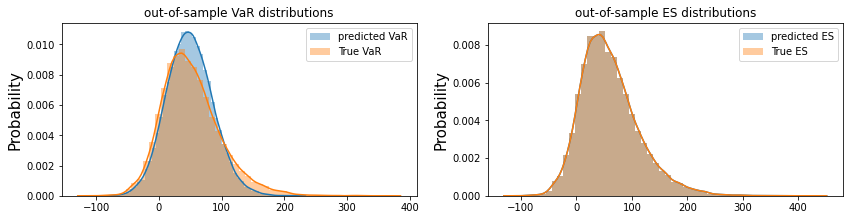

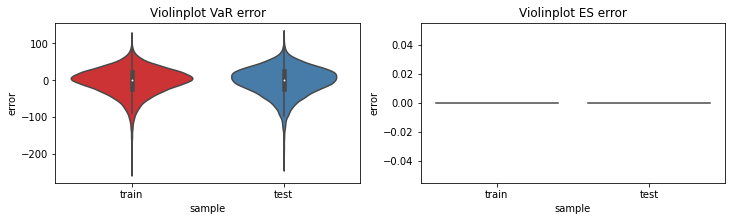

In [ ]:
plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

In [ ]:
%%time
RP_500layers_relu = Randomprojection(Layers=[dim_X,800], random_state= None, activation= F.relu, dist='Gauss')

var_NN = NN_nlayers(Layers=[800,1], activation =F.relu).to(device)

train_var_RUbased(var_NN, X_train_var= RP_500layers_relu.fit_transform(X_train),
                  y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 500, lr =0.1, pinball = 2)

===Train VaR process===
[iter 0] err = 32.605
[iter 500] err = -2.335
Best error = -2.3373868465423584
CPU times: user 492 ms, sys: 34.2 ms, total: 526 ms
Wall time: 525 ms


NRMSE in-sample VaR:  1.02265202999115
NRMSE in-sample ES:  0.0
NRMSE out-sample VaR:  1.0389180183410645
NRMSE out-sample ES:  0.0
Quantile loss in-sample:  2.063209295272827
Quantile loss out-sample:  2.5417537689208984
Quantile proba in-sample:  0.0215
Quantile proba out-sample:  0.03165


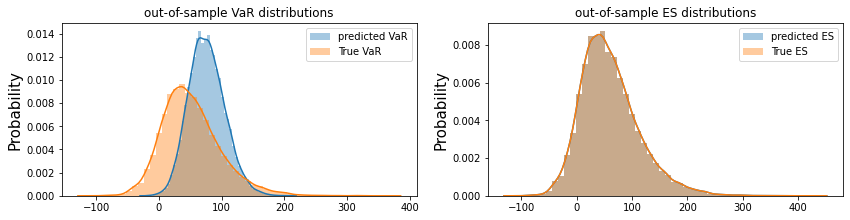

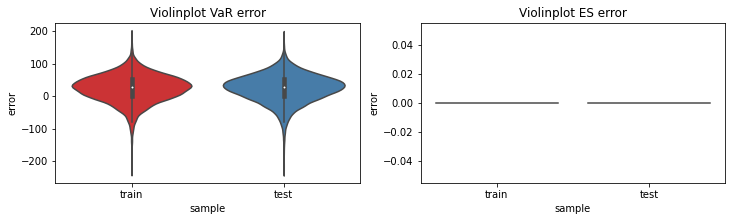

In [ ]:
plot_function(var_NN(RP_500layers_relu.fit_transform(X_train)), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(RP_500layers_relu.fit_transform(X_test)), true_VaR_test,
              true_ES_test, true_ES_test)

In [ ]:
%%time

RBF_hiddenlayer = RBFlayer(output_layer =1000, function ='thin plate spline', e = 0.2)
RBF_hiddenlayer.fit(X_train)

X_train_transformed = RBF_hiddenlayer.transform(X_train).data
X_test_transformed = RBF_hiddenlayer.transform(X_test).data

var_NN = NN_nlayers(Layers=[1000,1], activation =F.relu).to(device)

train_var_RUbased(var_NN, X_train_var= X_train_transformed,
                  y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 500, lr =0.1, pinball = 0)

===Train VaR process===
[iter 0] err = 115339.859
[iter 500] err = 314666.344
Best error = 29057.7265625
CPU times: user 11.1 s, sys: 3.31 s, total: 14.4 s
Wall time: 14.6 s


### Huber loss

In [ ]:
def train_var_huberloss(model_var, X_train_var, y_train, eps = eps,
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    ep = 2**-8
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        u = y_train - F.elu(model_var(X_train_var))
        hu = u**2/(2*ep)*(torch.abs(u)<=ep) + (torch.abs(u) - ep/2)*(torch.abs(u)>ep)
        loss_var = torch.mean((1-eps)*hu*(u>=zero_vector) + eps*hu*(u<zero_vector))
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        #err = loss_var.data.item()*X_train.shape[0]
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}, ep = {}'.format(i, round(err, 3), ep))
        i += 1
        if i % 10 ==0:
            ep *= 2**(-4)
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

In [ ]:
%%time
var_NN = NN_nlayers(Layers=[dim_X,500,1], activation =F.elu).to(device)

train_var_huberloss(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 20, lr = 0.1)

===Train VaR process===
[iter 0] err = 8.923, ep = 0.00390625
[iter 20] err = 2.626, ep = 1.52587890625e-05
[iter 40] err = 2.003, ep = 5.960464477539063e-08
[iter 60] err = 1.755, ep = 2.3283064365386963e-10
[iter 80] err = 1.674, ep = 9.094947017729282e-13
[iter 100] err = 1.644, ep = 3.552713678800501e-15
[iter 120] err = 1.528, ep = 1.3877787807814457e-17
[iter 140] err = 1.538, ep = 5.421010862427522e-20
[iter 160] err = 1.513, ep = 2.117582368135751e-22
[iter 180] err = 1.475, ep = 8.271806125530277e-25
[iter 200] err = 1.505, ep = 3.2311742677852644e-27
[iter 220] err = 1.416, ep = 1.262177448353619e-29
[iter 240] err = 2.106, ep = 4.930380657631324e-32
[iter 260] err = 1.546, ep = 1.925929944387236e-34
[iter 271] err = nan
CPU times: user 571 ms, sys: 106 ms, total: 677 ms
Wall time: 691 ms


NRMSE in-sample VaR:  0.8724640607833862
NRMSE in-sample ES:  0.0
NRMSE out-sample VaR:  0.9215871691703796
NRMSE out-sample ES:  0.0
Quantile loss in-sample:  2.450504779815674
Quantile loss out-sample:  4.717345237731934
Quantile proba in-sample:  0.1115
Quantile proba out-sample:  0.1621


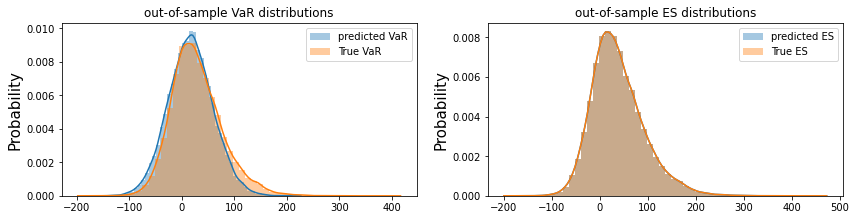

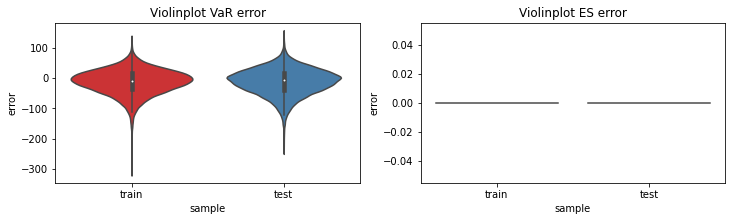

In [ ]:
plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

In [ ]:
%%time
RP_500layers_relu = Randomprojection(Layers=[dim_X,500], random_state= None, activation= F.relu)

var_NN = NN_nlayers(Layers=[500,1], activation =F.elu).to(device)

train_var_huberloss(var_NN, X_train_var= RP_500layers_relu.fit_transform(X_train), y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 500, lr =0.1)

===Train VaR process===
[iter 0] err = 8.764, ep = 0.00390625
[iter 261] err = nan
CPU times: user 389 ms, sys: 27.4 ms, total: 417 ms
Wall time: 424 ms


NRMSE in-sample VaR:  1.0752112865447998
NRMSE in-sample ES:  0.0
NRMSE out-sample VaR:  1.1005939245224
NRMSE out-sample ES:  0.0
Quantile loss in-sample:  2.452577829360962
Quantile loss out-sample:  2.827435255050659
Quantile proba in-sample:  0.0342
Quantile proba out-sample:  0.03745


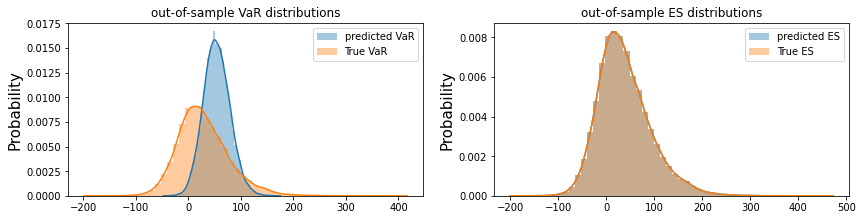

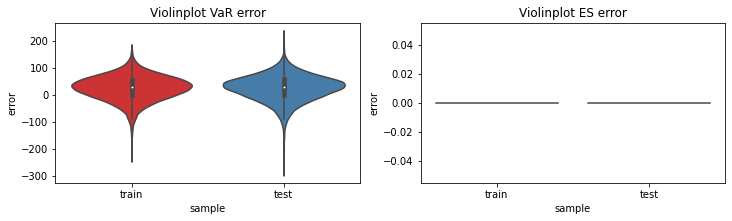

In [ ]:
plot_function(var_NN(RP_500layers_relu.fit_transform(X_train)), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(RP_500layers_relu.fit_transform(X_test)), true_VaR_test,
              true_ES_test, true_ES_test)

## 4.2 Linear program for quantile regression

Considering a quantile regression problem that we want to minimize the quantile loss:

$$\mathbb{E}\left[\ell(y,q)\right] =  \mathbb{E}\left[(y-q)^{+} - \epsilon(y-q)\right]$$

Approximated by 
\begin{align} 
\mathcal{L(q)} =& \frac{1}{n}\sum \left\{[y^{(i)}-q(X^{(i)})]^+ - \epsilon[y^{i} - q(X^{(i)})] \right\}\\
=&\frac{1}{n}\sum \left\{ (1-\epsilon)[y^{(i)}-q(X^{(i)})]^+ + \epsilon[y^{i} - q(X^{(i)})]^- \right\}
\end{align}

This loss (in the first line) can be divided by $\epsilon$ and then last term $y^i$ can be removed at the training step. This case leads to the trained loss in 5.1.

Now we try to rewrite the loss $\mathcal{L}$ to linear form (using the second line) as below:

$$ \mathcal{L}(q) = \frac{1}{n}\left[(1-\epsilon)1_n^Tu^+ + \epsilon1_n^Tu^- \right]$$

With $u = y-q$. Supposing, in addition, that $q(X)$ is a linear function of $X$: $q(X) =  \beta X$. The minimization problem can be reformulated as a linear programming problem:


\begin{align} 
\min_{z}& \hspace{0.5cm} c^Tz  \\
\mbox{subject to}:& \hspace{0.5cm} Az = b \\
 & \hspace{0.5cm} z \geq [-\infty 1_p \hspace{0.2cm} 0_{n} \hspace{0.2cm} 0_{n}]^T
\end{align}

Where
$$
c=\left[\begin{array}{c}
0_p \\
\frac{(1-\epsilon)}{n}1_n \\
\frac{(\epsilon)}{n}1_n
\end{array}\right] \quad z=\left[\begin{array}{c}
\beta \\
u^+ \\
u^-
\end{array}\right] \quad b = y
$$

$$A=\left[X_{n \times p} \hspace{0.2cm}  1_{n\times n} \hspace{0.2cm} \text{-}1_{n\times n}\right]\,  _{ n \times (p+2n)}$$

In [ ]:
class linear_quantreg:

    def __init__(self, eps = 0.025) :
        self.eps = eps

    def min_positive(self,vector):
        check = vector[vector>0]
        if check.nelement() == 0:
            return torch.tensor(np.inf).to(device)
        else:
            return check.min()
            
    def fit(self, X, y, tol = 1e-6, maxiter = 1000, verbose = 50):
        tau = 1 - self.eps
        n, p = X.shape
        with torch.no_grad():
            d = torch.ones(n, 1).to(device)
            c = -y
            b = (1-tau)*matmul(X.T,d)
            A = X.T
            y = matmul(A, c)
            ada = torch.cholesky(matmul(A,A.T), upper = True)
            y = torch.cholesky_solve(y, ada, upper = True)
            s = c.clone()
            s = s - matmul(A.T,y)
                    
            x = d*(1-tau)+1e-3
            
            z = torch.max(s, torch.tensor(0.).to(device)) + tol*(torch.abs(s)<tol)
            w = torch.max(-s, torch.tensor(0.).to(device))+ tol*(torch.abs(s)<tol)
            s = d-x

            i = 0
            gap = torch.sum(z*x) + torch.sum(w*s)
            while (gap > tol) and (i<= maxiter):
                
                # Compute predictor direction
                d = 1./(z/x+w/s)
                ds = z-w
                dz = d*ds
                dy = b.clone()
                dy = -matmul(A, x) + dy
                dy = matmul(A,dz) + dy
                rhs = dy.clone()
                try:
                    ada = torch.cholesky(matmul(A*d.T,A.T), upper = True)
                    dy = torch.cholesky_solve(dy, ada, upper = True)
                except:
                    break
                ds = matmul(A.T,dy)-ds
                dx = d*ds
                ds = -dx.clone()
                dz = -z*(1. + dx/x)
                dw = -w*(1. + ds/s)
                
                # Compute primal and dual steps
                alpha_p = torch.min(torch.min(self.min_positive(-x/dx),
                                              self.min_positive(-s/ds))*0.99995,
                                    torch.tensor(1.).to(device))
                alpha_d = torch.min(torch.min(self.min_positive(-z/dz),
                                              self.min_positive(-w/dw))*0.99995,
                                    torch.tensor(1.).to(device))
                if alpha_p*alpha_d <1 :
                    # Update mu
                    mu = torch.sum(z*x) + torch.sum(w*s)
                    g = torch.sum((z + alpha_d*dz)*(x + alpha_p*dx)) + torch.sum((w + alpha_d*w)*(s + alpha_p*ds))
                    mu = (g**3/mu**2)/(2.*n)
                    
                    # Compute corrector direction
                    dr = d*(mu*(1/s - 1/x) + dx*dz/x - ds*dw/s)
                    dy, rhs = rhs, dy
                    dy = matmul(A, dr)+dy
                    try:
                        dy = torch.cholesky_solve(dy, ada, upper = True)
                    except:
                        break
                    u = matmul(A.T, dy) 
                    dxdz = dx*dz
                    dsdw = ds*dw                    
                    dx = d*(u-z+w)-dr
                    ds = -dx.clone()
                    dz = mu/x - z*dx/x - z - dxdz/x
                    dw = mu/s - w*ds/s - w - dsdw/s
                    # Compute primal and dual steps
                    alpha_p = torch.min(torch.min(self.min_positive(-x/dx),
                                                  self.min_positive(-s/ds))*0.99995,
                                        torch.tensor(1.).to(device))
                    alpha_d = torch.min(torch.min(self.min_positive(-z/dz),
                                                  self.min_positive(-w/dw))*0.99995,
                                        torch.tensor(1.).to(device))
                # Update parameters

                y += alpha_d*dy
                z += alpha_d*dz
                w += alpha_d*dw
                x += alpha_p*dx
                s += alpha_p*ds
                gap = torch.sum(z*x) + torch.sum(s*w)
                if verbose != None:
                    if i % verbose ==0:
                        print(f'iter{i} | gap = {gap} | alpha_p = {alpha_p} | alpha_d = {alpha_d}')        
                i +=1
            if verbose != None:
                print(f'iter{i} | gap = {gap} | alpha_p = {alpha_p} | alpha_d = {alpha_d}')    
            self.y, self.z, self.w, self.x, self.s = y,z,w,x,s
            self.residu = z-w
            self.rho = torch.sum(z*tau + (1-tau)*w)

    def predict(self,X):
        return -matmul(X,self.y)


In [ ]:
%%time
rq = linear_quantreg(eps =eps)
rq.fit(X_train, Y_train, maxiter=500, verbose = None)

CPU times: user 2.2 s, sys: 630 ms, total: 2.83 s
Wall time: 2.84 s


NRMSE in-sample VaR:  59.576744079589844
NRMSE in-sample ES:  0.0
NRMSE out-sample VaR:  60.16691970825195
NRMSE out-sample ES:  0.0
Quantile loss in-sample:  1090.02001953125
Quantile loss out-sample:  1152.7406005859375
Quantile proba in-sample:  0.48245
Quantile proba out-sample:  0.49695


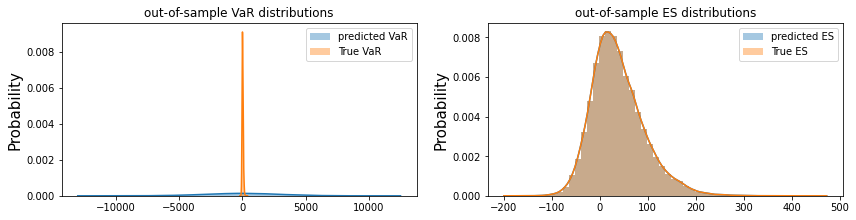

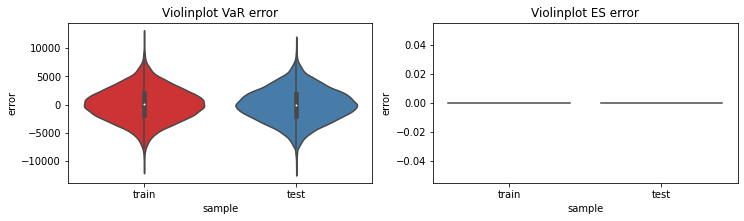

In [ ]:
plot_function(rq.predict(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              rq.predict(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

In [ ]:
%%time 
rq = linear_quantreg(eps = eps)
transform = Randomprojection([dim_X, 2000], activation = F.relu)
rq.fit(transform.fit_transform(X_train), Y_train, maxiter = 1000, verbose = 50)

iter0 | gap = 223232.875 | alpha_p = 0.0002558844571467489 | alpha_d = 0.012829610146582127
iter50 | gap = 715047.75 | alpha_p = 1.0 | alpha_d = 1.0
iter100 | gap = 685233.5 | alpha_p = 1.0 | alpha_d = 1.0
iter150 | gap = 652967.9375 | alpha_p = 1.0 | alpha_d = 1.0
iter200 | gap = 617714.125 | alpha_p = 1.0 | alpha_d = 1.0
iter250 | gap = 578706.4375 | alpha_p = 1.0 | alpha_d = 1.0
iter300 | gap = 534820.9375 | alpha_p = 1.0 | alpha_d = 1.0
iter350 | gap = 484269.40625 | alpha_p = 1.0 | alpha_d = 1.0
iter400 | gap = 423913.75 | alpha_p = 1.0 | alpha_d = 1.0
iter450 | gap = 347106.5625 | alpha_p = 1.0 | alpha_d = 1.0
iter500 | gap = 233397.59375 | alpha_p = 1.0 | alpha_d = 1.0
iter550 | gap = 99387.2890625 | alpha_p = 1.0 | alpha_d = 1.0
iter600 | gap = 82327.375 | alpha_p = 1.0 | alpha_d = 1.0
iter650 | gap = 75256.984375 | alpha_p = 1.0 | alpha_d = 1.0
iter700 | gap = 71897.078125 | alpha_p = 1.0 | alpha_d = 1.0
iter750 | gap = 70274.25 | alpha_p = 1.0 | alpha_d = 1.0
iter800 | gap = 

NRMSE in-sample VaR:  1.3187508583068848
NRMSE in-sample ES:  0.0
NRMSE out-sample VaR:  1.3592690229415894
NRMSE out-sample ES:  0.0
Quantile loss in-sample:  2.444932460784912
Quantile loss out-sample:  2.807661294937134
Quantile proba in-sample:  0.0001
Quantile proba out-sample:  0.01345


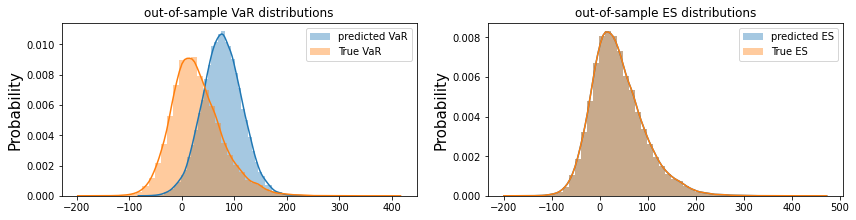

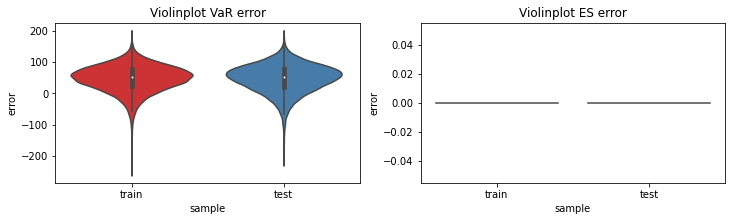

In [ ]:
plot_function(rq.predict(transform.fit_transform(X_train)), true_VaR_train,
              true_ES_train, true_ES_train,
              rq.predict(transform.fit_transform(X_test)), true_VaR_test,
              true_ES_test, true_ES_test)

In [ ]:
from statsmodels.regression.quantile_regression import QuantReg

In [ ]:
data_s

In [ ]:
model = QuantReg(Y_train.cpu().numpy(), X_train.cpu().numpy())

In [ ]:
res = model.fit(q=.975)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               -3.284
Model:                       QuantReg   Bandwidth:                       5.524
Method:                 Least Squares   Sparsity:                        112.4
Date:                Fri, 18 Sep 2020   No. Observations:                50000
Time:                        09:41:31   Df Residuals:                    49950
                                        Df Model:                           50
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2941      0.311      4.158      0.000       0.684       1.904
x2             0.1574      0.322      0.489      0.625      -0.474       0.789
x3             0.2580      0.323      0.799      0.425      -0.375       0.891
x4             2.5722      0.315      8.162      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


In [ ]:
!pip install mlinsights
from mlinsights.mlmodel import QuantileLinearRegression


In [ ]:
data_simulator()

In [ ]:
clq = QuantileLinearRegression(quantile= 0.975, max_iter=10, verbose=True, n_jobs=-1)

In [ ]:
transform = Randomprojection([dim_X, 800], activation = F.elu)


In [ ]:
%%time 
clq.fit(X_train.cpu().numpy(), Y_train.cpu().numpy().ravel())

[QuantileLinearRegression.fit] iter=1 error=304658.289963255
[QuantileLinearRegression.fit] iter=2 error=253861.77946436574
[QuantileLinearRegression.fit] iter=3 error=214482.89681929818
[QuantileLinearRegression.fit] iter=4 error=184181.5008565723
[QuantileLinearRegression.fit] iter=5 error=160891.68087891568
[QuantileLinearRegression.fit] iter=6 error=141769.58641137375
[QuantileLinearRegression.fit] iter=7 error=125988.40331787072
[QuantileLinearRegression.fit] iter=8 error=112055.46104045594
[QuantileLinearRegression.fit] iter=9 error=100288.11531439741
[QuantileLinearRegression.fit] iter=10 error=91429.67162847448
CPU times: user 393 ms, sys: 316 ms, total: 709 ms
Wall time: 426 ms


QuantileLinearRegression(n_jobs=-1, quantile=0.975, verbose=True)

NRMSE in-sample VaR:  1.0023282948571217
NRMSE in-sample ES:  0.0
NRMSE out-sample VaR:  1.002528177284492
NRMSE out-sample ES:  0.0
Quantile loss in-sample:  4.571482623021827
Quantile loss out-sample:  4.4788278190415145
Quantile proba in-sample:  0.1362
Quantile proba out-sample:  0.13055


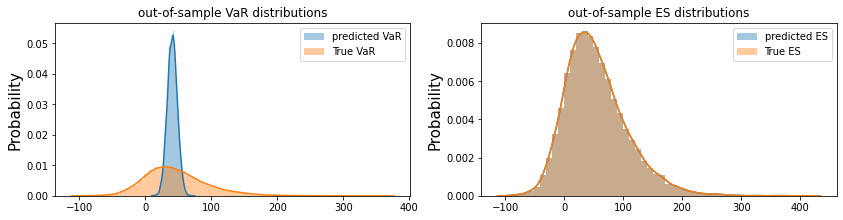

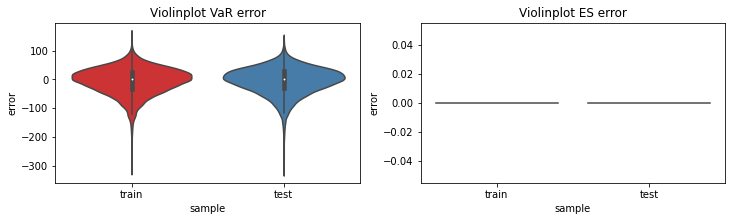

In [ ]:
plot_function(torch.from_numpy(clq.predict(X_train.cpu())).reshape(-1,1).to(device), true_VaR_train,
              true_ES_train, true_ES_train,
              torch.from_numpy(clq.predict(X_test.cpu())).reshape(-1,1).to(device), true_VaR_test,
              true_ES_test, true_ES_test)

In [ ]:
clq.coef_

array([ 5.85444178e-02,  4.85549475e-01,  8.40313807e-01,  9.45533646e-01,
       -5.10105015e-01,  1.28434035e-01,  4.23940589e-01,  9.52214639e-01,
        5.51721985e-01, -1.04602330e+00, -1.25500369e+00,  1.29195236e+00,
       -1.79721152e+00,  9.21072673e-01, -5.98054589e-01,  1.03742437e+00,
        7.79153021e-01, -1.22911254e+00, -8.82859369e-01, -4.45120218e-02,
       -1.92609812e-02,  4.97687774e-01,  9.20811964e-01, -2.92612360e+00,
       -1.53802048e+00,  3.23462849e-01, -8.84976704e-02,  6.95291527e-01,
        9.34036315e-01,  4.86421177e-01, -1.33251414e+00, -1.66152868e-03,
        6.49424464e-01,  1.53541473e+00, -8.76775854e-01,  3.55454863e-01,
        1.14910748e+00,  1.20769767e+00,  1.99577125e+00, -2.51323691e-01])

## 4.3 Interior point for one-hidden-layer networks

In [ ]:
data_simulator(dim_X = 10, nb_path=5000)

In [ ]:
%%time

sigma = F.softplus
sigma_p = lambda x: 1./(1. + torch.exp(-x))

A = X_train
y = Y_train
tau = 1-eps
tol = 1e-6 
maxiter = 1000
verbose = 1

n,k = A.shape
p = 100

W_t = torch.rand(p*k,1, requires_grad = True).to(device)
W = W_t.reshape(p,k).T
b = torch.rand(p,1, requires_grad = True).to(device)

res = y - matmul(sigma(matmul(A, W)), b)
u = torch.max(res, torch.tensor(0.).to(device))
v = torch.max(-res, torch.tensor(0.).to(device))

d = torch.ones(n, 1).to(device)

a = d*(1-tau)+0.05
s = d-a

gap = torch.sum(s*u) + torch.sum(a*v)

i = 0

def min_positive(vector):
    check = vector[vector>0]
    if check.nelement() == 0:
        return torch.tensor(np.inf).to(device)
    else:
        return check.min()

while (gap > tol) and (i<= maxiter):
    
    z1 = sigma(matmul(A,W))
    G_1 = 1./(u/s+v/a)
    r1 = - matmul(z1.T, a + tau - 1)
    r2 = - (matmul(A.T,matmul(a + tau - 1, b.T)*sigma_p(matmul(A,W)))).T.reshape(-1,1)
    r3 = - matmul(z1,b) + y

    Q = jacobian(-r1, W_t).squeeze()
    K = jacobian(-r3, W_t).squeeze()
    M = jacobian(-r2, W_t).squeeze()
    
    N = Q - matmul(z1.T*G_1.T,K)
    z1_G1_z1_inv = torch.inverse(matmul(z1.T*G_1.T, z1))

    rhs = r2- matmul(K.T*G_1.T, r3) + matmul(matmul(N.T,z1_G1_z1_inv),r1-matmul(z1.T*G_1.T,r3))
    try:
        lhs_inv = torch.inverse(matmul(matmul(N.T, z1_G1_z1_inv),N) + M-matmul(K.T*G_1.T,K))
        dW_t = matmul(lhs_inv, rhs)
    except:
        break
    db = matmul(z1_G1_z1_inv, matmul(N,dW_t) - r1 + matmul(z1.T*G_1.T,r3))
    da = G_1*(r3 - matmul(z1,db) - matmul(K,dW_t))
    ds = -da
    du = -u*(1. + ds/s)
    dv = -v*(1. + da/a)

    # Compute primal and dual steps
    alpha_p = torch.min(torch.min(min_positive(-a/da),
                                  min_positive(-s/ds))*0.99995,
                        torch.tensor(1.).to(device))
    alpha_d = torch.min(torch.min(min_positive(-u/du),
                                  min_positive(-v/dv))*0.99995,
                        torch.tensor(1.).to(device))

    if alpha_p*alpha_d < 1 :
        # Update mu        
        g = torch.sum((s + alpha_p*ds)*(u + alpha_d*du)) + torch.sum((a + alpha_p*a)*(v + alpha_d*dv))
        mu = (g**3/gap**2)/(2.*n)
        
        # Compute corrector direction
        dr3 = mu*(1./a - 1./s) + ds*du - da*dv
        rhs -= matmul(K.T*G_1.T + matmul(matmul(N.T,z1_G1_z1_inv),z1.T*G_1.T), dr3)
        try:
            dW_t = matmul(lhs_inv, rhs)
        except:
            break
        
        db = matmul(z1_G1_z1_inv, matmul(N,dW_t) - r1 + matmul(z1.T*G_1.T,r3+dr3)) 
        dsdu = ds*du
        dadv = da*dv 
        da = G_1*(r3+dr3-matmul(z1,db) - matmul(K,dW_t))                   
        ds = -da
        du = mu/s - u - u*ds/s - dsdu
        dv = mu/a - v - v*da/a - dadv
        # Compute primal and dual steps
        alpha_p = torch.min(torch.min(min_positive(-a/da),
                                  min_positive(-s/ds))*0.99995,
                        torch.tensor(1.).to(device))
        alpha_d = torch.min(torch.min(min_positive(-u/du),
                                      min_positive(-v/dv))*0.99995,
                            torch.tensor(1.).to(device))
    # Update parameters
    b = b.clone() + alpha_d*db
    W_t = W_t.clone() + alpha_d*dW_t
    W = W_t.reshape(p,k).T
    u += alpha_d*du
    v += alpha_d*dv
    a += alpha_p*da
    s += alpha_p*ds
    gap = torch.sum(s*u) + torch.sum(a*v)
    target = torch.sum(u*tau + (1-tau)*v)
    if verbose != None:
        if i % verbose ==0:
            print(f'iter{i} | gap = {gap} | target = {target} | alpha_p = {alpha_p} | alpha_d = {alpha_d}')        
    i +=1



In [ ]:
Q

In [ ]:
%%time

sigma = F.softplus
sigma_p = lambda x: 1./(1. + torch.exp(-x))

A = X_train
y = Y_train
tau = 1-eps
tol = 1e-6 
maxiter = 1000
verbose = 1

n,k = A.shape
p = 100

W_t = torch.rand(p*k,1, requires_grad = True).to(device)
W = W_t.reshape(p,k).T
b = torch.rand(p,1, requires_grad = True).to(device)

res = y - matmul(sigma(matmul(A, W)), b)
u = torch.max(res, torch.tensor(0.).to(device))
v = torch.max(-res, torch.tensor(0.).to(device))

d = torch.ones(n, 1).to(device)

a = d*(1-tau)+0.05
s = d-a

gap = torch.sum(s*u) + torch.sum(a*v)
mu = 10000
i = 0

def min_positive(vector):
    check = vector[vector>0]
    if check.nelement() == 0:
        return torch.tensor(np.inf).to(device)
    else:
        return check.min()

while (gap > tol) and (i<= maxiter):
    
    z1 = sigma(matmul(A,W))
    G_1 = 1./(u/s+v/a)
    r1 = - matmul(z1.T, a + tau - 1)
    r2 = - (matmul(A.T,matmul(a + tau - 1, b.T)*sigma_p(matmul(A,W)))).T.reshape(-1,1)
    r3 = - matmul(z1,b) + y + mu*(1/a - 1/s)

    Q = jacobian(-r1, W_t).squeeze()
    K = jacobian(-r3, W_t).squeeze()
    M = jacobian(-r2, W_t).squeeze()
    
    N = Q - matmul(z1.T*G_1.T,K)
    z1_G1_z1_inv = torch.inverse(matmul(z1.T*G_1.T, z1))

    rhs = r2- matmul(K.T*G_1.T, r3) + matmul(matmul(N.T,z1_G1_z1_inv),r1-matmul(z1.T*G_1.T,r3))
    try:
        lhs_inv = torch.inverse(matmul(matmul(N.T, z1_G1_z1_inv),N) + M-matmul(K.T*G_1.T,K))
        dW_t = matmul(lhs_inv, rhs)
    except:
        break
    db = matmul(z1_G1_z1_inv, matmul(N,dW_t) - r1 + matmul(z1.T*G_1.T,r3))
    da = G_1*(r3 - matmul(z1,db) - matmul(K,dW_t))
    ds = -da
    du = -u*(1. + ds/s)+mu/s
    dv = -v*(1. + da/a)+mu/a

    # Compute primal and dual steps
    alpha_p = torch.min(torch.min(min_positive(-a/da),
                                  min_positive(-s/ds))*0.99995,
                        torch.tensor(1.).to(device))
    alpha_d = torch.min(torch.min(min_positive(-u/du),
                                  min_positive(-v/dv))*0.99995,
                        torch.tensor(1.).to(device))

    # Update parameters
    b = b.clone() + alpha_d*db
    W_t = W_t.clone() + alpha_d*dW_t
    W = W_t.reshape(p,k).T
    u += alpha_d*du
    v += alpha_d*dv
    a += alpha_p*da
    s += alpha_p*ds
    gap = torch.sum(s*u) + torch.sum(a*v)
    target = torch.sum(u*tau + (1-tau)*v)
    if verbose != None:
        if i % verbose ==0:
            print(f'iter{i} | gap = {gap} | target = {target} | alpha_p = {alpha_p} | alpha_d = {alpha_d}')        
    i +=1



In [ ]:
torch.det(lhs[0:2,0:2])

### Some test function

In [ ]:
def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                                                                      
def hessian(y, x, x2 = None):
    if x2 ==None:                                                                                    
        return jacobian(jacobian(y, x, create_graph=True), x)      
    else:
        return jacobian(jacobian(y, x, create_graph=True), x2) 

In [ ]:
sigma = F.softplus
sigma_p = lambda x: 1./(1. + torch.exp(-x))

W_t = torch.rand(5*50, requires_grad= True)
W = W_t.reshape(50,5).T
A = torch.rand(5000,5)
b = torch.rand(50,1, requires_grad=True)
a = torch.rand(5000,1, requires_grad=True)

L = matmul(matmul(sigma(matmul(A,W)), b).T, a)
L_j = lambda x: matmul(matmul(sigma(matmul(A,x.reshape(50,5).T)), b).T, a) 
r2_j = lambda x: (matmul(A.T,matmul(a, b.T)*sigma_p(matmul(A,x)))).T.reshape(-1,1)

In [ ]:
A = torch.rand(3,5)

In [ ]:
A.shape

In [ ]:
A*torch.eye(5)

In [ ]:
%%time
torch.autograd.functional.hessian(L_j, W_t).shape

In [ ]:
%%time
jacobian(matmul(sigma(matmul(A,W)).T,a), W_t).shape

In [ ]:
%%time
hessian(L,b,W_t)[0,0,:,0,:]